# Team Details

CIS 5450: BIG DATA ANALYTICS PROJECT

Penn Engineering, University of Pennsylvania

`Group 36:`
- Aditya Jayant G (adityajg@seas.upenn.edu)
- Meet Gandhi (mgandhi5@seas.upenn.edu)
- Shikha Reddy (shikham@seas.upenn.edu)

# Installing Libraries

In [ ]:
%%capture
!pip install wordtree
!pip install pyvis

Mounting Drive to acces the dataset from the project drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import itertools
import json
import os
import re
from collections import Counter
from datetime import datetime
from itertools import islice

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import wordtree
from IPython.core.display import HTML, display
from PIL import Image
from pyvis.network import Network
from sklearn import metrics
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from spacy import displacy
from tqdm.auto import tqdm
from wordcloud import STOPWORDS, WordCloud
from xgboost import XGBClassifier

nltk.download('punkt')

tqdm.pandas()
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Common Utils

Text Cleaning Function implementation for Data Cleaning


In [ ]:
def clean_text(text):
    # removing non-ascii chars
    text = text.encode('ascii', errors='ignore').decode()
    # removing LaTeX
    text = re.sub(r'\$(\s*[\s\S]*?\s*)\$', '', text)
    # keeping only english characters and digits
    text = re.sub(r'[^\w\s,.]+', ' ', text)
    # removing multiple `.`
    text = re.sub(r'\.\s*\.', '.', text)
    # removing multiple `,`
    text = re.sub(r'\,\s*\,', ',', text)
    return " ".join(text.split())


def load_chunk(path, cols, start_idx=0, chnk_size=500):
    def generate_records(path):
        with open(path) as f:
            for row in f:
                d = json.loads(row)
                d['labels'] = list(
                    set([x.split(".")[0] for x in d["categories"].split()])
                )
                if 'authors' in cols:
                    d['authors'] = [
                        ' '.join(x).strip() for x in d['authors_parsed'] 
                        if ' '.join(x).strip() != ''
                        ]
                yield {k:v for k,v in d.items() if k in cols}
    
    df = pd.DataFrame(
        list(
            islice(generate_records(path), start_idx, start_idx + chnk_size, 1)
        )
    )
    return df

In [ ]:
PATH = "/content/drive/Shareddrives/CIS545-Project/data"

# Exploratory Data Analysis

Loading Required data

Choosing only the relevant categories from data from the dataset

In [ ]:
#loading a large dataset and extracting certain columns
data = load_chunk(
    f"{PATH}/arxiv-metadata-oai-snapshot.json",
    ['id', 'title', 'labels', 'authors', 'versions','update_date'],
    chnk_size=2300000
)

## Checking Null Values

In [ ]:
#checking for null counts
print("Data size: ", data.shape)
data.isnull().sum()

Data size:  (2223467, 6)


id             0
authors        0
title          0
versions       0
update_date    0
labels         0
dtype: int64

## Data Cleaning

In [ ]:
data.head()

id                                                 authors  \
0  0704.0001  [Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]   
1  0704.0002                          [Streinu Ileana, Theran Louis]   
2  0704.0003                                           [Pan Hongjun]   
3  0704.0004                                          [Callan David]   
4  0704.0005                 [Abu-Shammala Wael, Torchinsky Alberto]   

                                                                                        title  \
0    Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies   
1                                                    Sparsity-certifying Graph Decompositions   
2        The evolution of the Earth-Moon system based on the dark matter field\n  fluid model   
3  A determinant of Stirling cycle numbers counts unlabeled acyclic\n  single-source automata   
4                                        From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\alpha}$   

                                                                                                                                                versions  \
0                          [{'version': 'v1', 'created': 'Mon, 2 Apr 2007 19:18:42 GMT'}, {'version': 'v2', 'created': 'Tue, 24 Jul 2007 20:10:27 GMT'}]   
1                         [{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]   
2  [{'version': 'v1', 'created': 'Sun, 1 Apr 2007 20:46:54 GMT'}, {'version': 'v2', 'created': 'Sat, 8 Dec 2007 23:47:24 GMT'}, {'version': 'v3', 'cr...   
3                                                                                        [{'version': 'v1', 'created': 'Sat, 31 Mar 2007 03:16:14 GMT'}]   
4                                                                                         [{'version': 'v1', 'created': 'Mon, 2 Apr 2007 18:09:58 GMT'}]   

  update_date      labels  
0  2008-11-26    [hep-ph]  
1  2008-12-13  [math, cs]  
2  2008-01-13   [physics]  
3  2007-05-23      [math]  
4  2013-10-15      [math]

Run certain Dataset columns through the text cleaning function

In [ ]:
# applying the text cleaning function to the title column 
data['title'] = data['title'].progress_apply(clean_text)

  0%|          | 0/2223467 [00:00<?, ?it/s]

In [ ]:
data.head()

id                                                 authors  \
0  0704.0001  [Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]   
1  0704.0002                          [Streinu Ileana, Theran Louis]   
2  0704.0003                                           [Pan Hongjun]   
3  0704.0004                                          [Callan David]   
4  0704.0005                 [Abu-Shammala Wael, Torchinsky Alberto]   

                                                                                     title  \
0    Calculation of prompt diphoton production cross sections at Tevatron and LHC energies   
1                                                 Sparsity certifying Graph Decompositions   
2        The evolution of the Earth Moon system based on the dark matter field fluid model   
3  A determinant of Stirling cycle numbers counts unlabeled acyclic single source automata   
4                                                                           From dyadic to   

                                                                                                                                                versions  \
0                          [{'version': 'v1', 'created': 'Mon, 2 Apr 2007 19:18:42 GMT'}, {'version': 'v2', 'created': 'Tue, 24 Jul 2007 20:10:27 GMT'}]   
1                         [{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]   
2  [{'version': 'v1', 'created': 'Sun, 1 Apr 2007 20:46:54 GMT'}, {'version': 'v2', 'created': 'Sat, 8 Dec 2007 23:47:24 GMT'}, {'version': 'v3', 'cr...   
3                                                                                        [{'version': 'v1', 'created': 'Sat, 31 Mar 2007 03:16:14 GMT'}]   
4                                                                                         [{'version': 'v1', 'created': 'Mon, 2 Apr 2007 18:09:58 GMT'}]   

  update_date      labels  
0  2008-11-26    [hep-ph]  
1  2008-12-13  [math, cs]  
2  2008-01-13   [physics]  
3  2007-05-23      [math]  
4  2013-10-15      [math]

## Publications by category across the years (top 10)

Counting Labels in a Dataset

Taking all the unique labels/categories present in a given dataset and counts the number of occurrences of each label in the dataset. It creates a new dataframe with the label and its corresponding count, sorted by the count in descending order.

In [ ]:
# counting the total number of publications and sorting
all_labels = list(
    itertools.chain.from_iterable(data['labels'].tolist())
)
# Using Count function to get the total publications per label.
all_labels = pd.DataFrame(
    all_labels, columns=['category']
).groupby('category')['category'].count().to_frame().rename(
    columns={'category': 'count'}
).reset_index().sort_values('count', ascending=False)

In [ ]:
# plotting the bar plot!
fig = px.bar(
    all_labels.head(10), x='category', y='count',
    title="Publications By Category, Across the Years", width=800, height=500
)
fig.show()

As seen in the graph above, Math and Computer Science publications lead the way. Further, it tells us about the most active domains across the years. Next, we analyze how publications are distributed across the categories.

## Distribution of number of labels

In [ ]:
# Plotting histogram for distribution of labels in terms of count.
data['label_count'] = data['labels'].apply(lambda x: len(x)) # number of labels per publiction!
fig = px.histogram(
    data, x="label_count", nbins=10,
    title='Distribution of number of labels', width=800, height=500
)
fig.show()
data = data.drop(columns=['label_count'])

As expected, the majority of publications have one label. But, we also have a sizable number belonging to two and even three categories. It prompts us to develop a multilabel-multiclass classification model for article tagging later.

## Time Series: Number of publications by year 

Publications by Year

We extract the year of the first version for each paper and groups the papers by year, counting the number of publications in each year.

In [ ]:
# Extract year of first version for each paper
data['first_version_year'] = data['versions'].apply(
    lambda x: datetime.strptime(
        x[0]['created'], '%a, %d %b %Y %H:%M:%S %Z'
    ).year)

# Group by year and count papers 
publications_per_year = data[data['first_version_year']>=1991].groupby(
    'first_version_year'
)['labels'].count().reset_index()

In [ ]:
# Create line plot for new publications per year
fig = px.line(publications_per_year, x='first_version_year', y='labels')

fig.add_trace(
    go.Scatter(
        x=publications_per_year['first_version_year'],
        y=publications_per_year['labels'],
        mode='lines+markers', name='Publications')
)
# Setting the descriptions
fig.update_layout(
    title='New Publications on ArXiv, by Year',
    xaxis_title='Year', yaxis_title='Number of publications'
)
fig.show()

Arxiv database was created in 1991, so it makes sense that there are next to null publications in the initial years. But since then, the number of publications has increased exponentially, which provides a strong indication of Free and Open Research. The exponential trend is broken between the years 2020 and 2022, which could be due to the covid-19 pandemic. The graph goes down in 2023 because the dataset only captures publications from its first few months.

## Time Series: Version updates over years

### Single-Multiple version update count by year

In [ ]:
# create a new column to indicate number of versions for each paper
data['num_versions'] = data['versions'].apply(len)

# group by label and number of versions and count the number of papers in each group
versions_count = data.groupby(
    ['first_version_year','num_versions']
).size().reset_index(name='count')

versions_count.loc[versions_count['num_versions']==1, 'version_type'] = 'Single'
versions_count.loc[versions_count['num_versions']>1, 'version_type'] = 'Multiple'

versions_count = versions_count.groupby(
    ['first_version_year', 'version_type']
)['count'].sum().reset_index()

versions_count['total'] = versions_count.groupby(
        'first_version_year'
    )['count'].transform('sum')

versions_count['count_percentage'] = round(
    100 * versions_count['count']/versions_count['total']
    ).astype('int')

fig = px.bar(
    versions_count[versions_count['first_version_year']>=1991],
    x="first_version_year", y="count", color="version_type",
    title="Publications with Single & Multiple Updates, by Year"
)

# Update the layout
fig.update_layout(
    xaxis_title='Release Year', yaxis_title='Count'
)

# Show the plot
fig.show()

In the above plot, we see the count of both single and multiple-version publications increasing. Further, the fraction of single and multiple-version studies seems to remain constant. So, we'll next look at the plot of the percentage split between them.

### Single-Multiple version update percentage split by year

In [ ]:
#plot the graph for multiple version updates
fig = px.bar(
    versions_count[versions_count['first_version_year']>=1991],
    x="first_version_year", y="count_percentage", color="version_type",
    title="Percentage of publications with Single & Multiple Updates, by Year"
)

# Update the layout
fig.update_layout(
    xaxis_title='Release Year', yaxis_title='Count Percentage'
)

# Show the plot
fig.show()

We see an interesting trend here. The fraction of studies updated multiple times increased monotonically from 1991 to 2020 but then reduced sharply, which we can most likely attribute to covid-19, which led research into various new directions.

## Frequency of updates by category in 2022

A stacked bar plot showing the count of papers per category (first release only, updated later) for a selected year.

In [ ]:
#set year
year = 2022

df = data[data['first_version_year'] == year]

# explode the labels column into separate rows
df_labels = df.explode('labels')

df_labels = df_labels.reset_index(drop=True)

# create a new column to indicate number of versions for each paper
df_labels['num_versions'] = df_labels['versions'].apply(len)

# group by label and number of versions and count the number of papers in each group
versions_count = df_labels.groupby(
    ['labels','num_versions']
).size().reset_index(name='count')

versions_count.loc[versions_count['num_versions']==1, 'version_type'] = 'Single'
versions_count.loc[versions_count['num_versions']>1, 'version_type'] = 'Multiple'

versions_count = versions_count.groupby(
    ['labels', 'version_type']
)['count'].sum().reset_index()
#using groupby on labels
versions_count['total'] = versions_count.groupby(
        'labels'
    )['count'].transform('sum')

versions_count['count_percentage'] = round(
    100 * versions_count['count']/versions_count['total']
    ).astype('int')

fig = px.bar(
    versions_count.sort_values('total', ascending=False),
    x="labels", y="count", color="version_type",
    title="Publications with Single & Multiple Updates, by Category for 2022"
)

# Update the layout
fig.update_layout(
    xaxis_title='Category', yaxis_title='Count'
)

# Show the plot
fig.show()

It is interesting that in 2022, computer science had the highest number of publications, which is different from the overall publication distribution where math stands at the first rank. Next, we look at the percentage split between single and multiple publications by category for 2022.

In [ ]:
#sort the total column in desc order and let labels for the plot
fig = px.bar(
    versions_count.sort_values('total', ascending=False),
    x="labels", y="count_percentage", color="version_type",
    title="Percentage of publications with Single & Multiple Updates, by Category for 2022"
)

# Update the layout
fig.update_layout(
    xaxis_title='Category', yaxis_title='Count Percentage'
)

# Show the plot
fig.show()

ArXiv category taxonomy: https://arxiv.org/category_taxonomy

Even though Computer Science has the highest number of total publications, it has one of the lowest fractions of publications with multiple versions. It could indicate that authors do not build upon existing research very often or there is a lot of innovation in the field. Further, we see a lot of multiple-version publications in "hep-th" (High Energy Physics - Theory), which implies that researchers are building a lot on top of their existing publications in that domain.

Next, we'll look at some text visualizations!

## Word trees by category (top 2)

WordTree Function Implementation

A function that generates a keyword tree plot for a given corpus of text, highlighting the occurrences of a specific keyword. Can be used on the entire corpus or a subset of documents belonging to a specific category.

In [ ]:
# Defining the wordtree plot!
def plot_wordtree(data, key_word, category=None, col_to_use='title', size=(800, 600)):
    """
    Searches for the occurrence of a keyword in a corpus of documents and visualizes a word tree.

    Args:
    - data: pandas DataFrame. The corpus of documents to search in.
    - key_word: str. The keyword to search for.
    - category: str or None. If specified, restricts the search to documents belonging to a certain category.
    - col_to_use: str. The name of the column in `data` that contains the text to search in.
    - size: tuple of ints. The size in pixels of the output image.
    """
    if category:
        data['flag'] = data['labels'].apply(lambda x: 1 if category in x else 0)
        docs = data[data['flag']==1][col_to_use].tolist()
        data = data.drop(columns=['flag'])
        print(f"Found {len(docs)} documents in {category}!!")
    else:
        docs = data[col_to_use].tolist()
        print("Using the entire corpus!!")
    g = wordtree.search_and_draw(corpus = docs, keyword = key_word)
    g.view(f"{category}_wordtree", cleanup=True)
    im = Image.open(f"./{category}_wordtree.png")
    im.resize(size).show()

Found 584202 documents in math!!


  0%|          | 0/584202 [00:00<?, ?it/s]

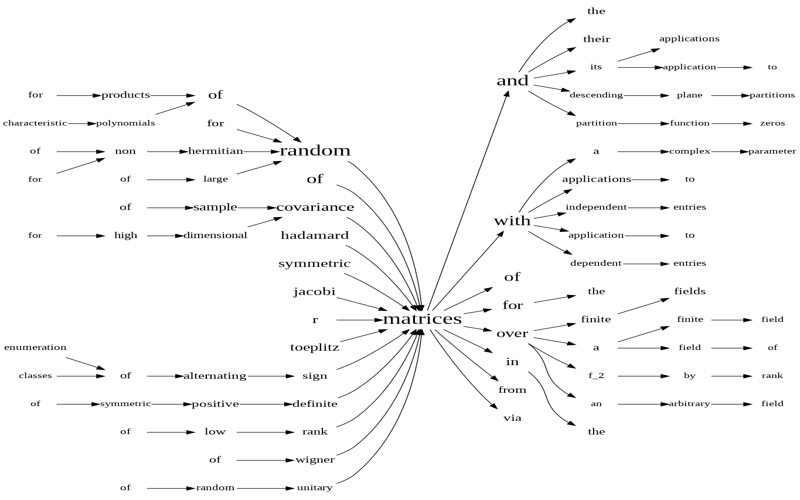

In [ ]:
plot_wordtree(data, 'matrices', category='math', size=(800, 500))

Found 498573 documents in cs!!


  0%|          | 0/498573 [00:00<?, ?it/s]

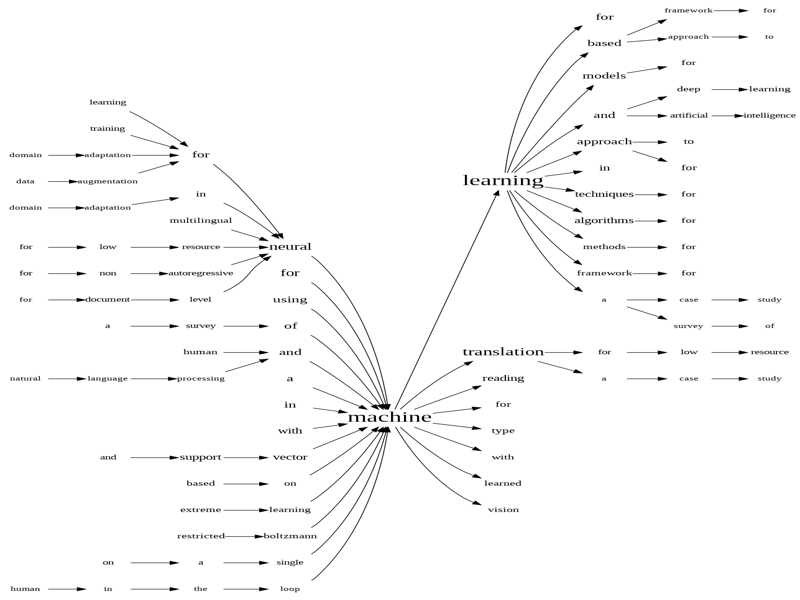

In [ ]:
plot_wordtree(data, 'machine', category='cs')

Word trees provide an interesting way to visualize text data with respect to a particular keyword. In the plot above, for math and computer science, we can see how words are distributed w.r.t to words "matrices" and "machine." It also explains how our category classification model (developed below) will distinguish the different labels.

## Word cloud by category (top 4)

Word Cloud Visualization for Corpus or Category

A function which creates a word cloud based on a given corpus or category of text data, and another function that plots multiple word clouds in a grid with corresponding titles.

In [ ]:
# define the wordcloud visualization function!
def get_wordcloud(data, category, col_to_use='title', size=(1200, 800)):
    """
    Generates a word cloud based on the text contained in a DataFrame column, optionally restricted to a certain category.

    Args:
    - data: pandas DataFrame. The corpus of documents to generate the word cloud from.
    - category: str or None. If specified, restricts the word cloud to documents belonging to a certain category.
    - col_to_use: str. The name of the column in `data` that contains the text to use for the word cloud.
    - size: tuple of ints. The size in pixels of the output image.

    Returns:
    A `WordCloud` object containing the generated word cloud.
    """
    if category:
        data['flag'] = data['labels'].apply(lambda x: 1 if category in x else 0)
        docs = data[data['flag']==1][col_to_use].tolist()
        data = data.drop(columns=['flag'])
        print(f"Found {len(docs)} documents in {category}!!")
    else:
        docs = data[col_to_use].tolist()
        print("Using the entire corpus!!")
    
    wordcloud =  WordCloud(
        width = size[0], height = size[1], stopwords=STOPWORDS,
        background_color ='lavender', min_font_size = 10
    ).generate(" ".join(docs))
    return wordcloud


def plot_wordclouds(word_cloud_list, title_lst, nrows, ncols, size=(12, 7)):
    """
    Plots a list of word clouds as subplots in a grid.

    Args:
    - word_cloud_list: list of `WordCloud` objects. The word clouds to plot.
    - title_lst: list of str. The titles to use for each subplot.
    - nrows: int. The number of rows in the subplot grid.
    - ncols: int. The number of columns in the subplot grid.
    - size: tuple of ints. The size in inches of the output figure.

    Returns:
    None. The function displays the plot in a new window.
    """
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=size
    )
    # iterate through each subplot and create a word cloud
    for i, ax in enumerate(axs.flat):
        # plot the word cloud in the current subplot
        ax.imshow(word_cloud_list[i], interpolation='bilinear')
        ax.set_title(f'Word Cloud: {title_lst[i]}')
        ax.axis('off')
    # adjust subplot spacing
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    # show the plot
    plt.show()

In [ ]:
category_lst = ['math', 'cs', 'cond-mat', 'astro-ph']
cloud_lst = [get_wordcloud(data, c) for c in category_lst]

Found 584202 documents in math!!
Found 498573 documents in cs!!
Found 345913 documents in cond-mat!!
Found 320195 documents in astro-ph!!


Word Clouds for different popular categories

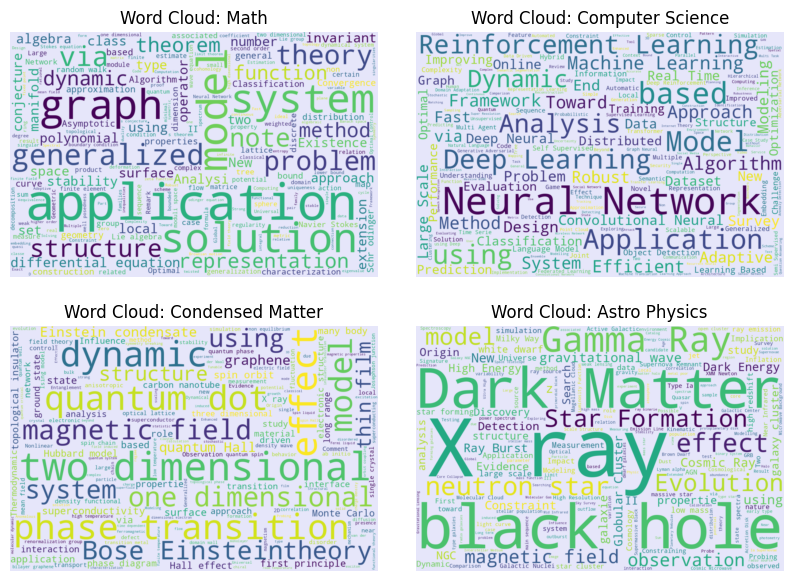

In [ ]:
title_list = ["Math", 'Computer Science', 'Condensed Matter', 'Astro Physics']
plot_wordclouds(cloud_lst, title_list, 2, 2, size=(10,7))

 - In math publications, the words like "differential equation," "graph," and "system" come up, indicating research work in calculus, topography, algebra, and modeling.

 - As expected, Neural Networks is the biggest word in the cs publications. Further, we also see other words like Machine, Reinforcement, and Deep Learning. These are usually words we associate with CS research.

 - For condensed matter, we see words like Quantum dot, Phase transition, and Magnetic field, which makes sense too.

 - It is also fun to look at astro physics word cloud, which has words like Black Hole, Dark Matter, X-Ray, etc. It helps us understand the biggest research topics in astro physics.

Overall, word clouds provide a rough sense of the vocabulary of words in the different domains. It could also explain how a category classification model would work if we used feature creation techniques like Term Frequency - Inverse Document Frequency (TF-IDF).

## Co-Authorship Graph

Now, we'll build an author-author graph for the most published domain (Math) using Networkx and generate some interactive visualizations using Pyvis Library

In [ ]:
DOMAIN = 'math'

In [ ]:
def get_author_author_graph(category, to_take=100):
    """
    Generates a graph of author-author co-occurrences in a given category of documents.

    Parameters:
    category (str): The category of documents to consider for generating the graph.
    to_take (int or float, optional): The number or proportion of top authors to include in the graph. 
                                       Defaults to 100.

    Returns:
    g (networkx.DiGraph): The generated graph of author-author co-occurrences.
    """
    data['flag'] = data['labels'].apply(lambda x: 1 if category in x else 0)
    authors = data[data['flag']==1]['authors'].tolist()
    print(f"Found {len(authors)} documents in {category}!!")
    
    author_counts = Counter(itertools.chain.from_iterable(authors))
    unique_authors = set(author_counts.keys())
    print(f"There are {len(unique_authors)} unique authors.")
    
    # selecting top n authors
    if isinstance(to_take, float):
        top_n = int(len(unique_authors) * to_take)
    else:
        top_n = to_take

    author_counts = dict(sorted(
        author_counts.items(), key=lambda x: x[1], reverse=True
        )[:top_n])
    unique_authors = set(author_counts.keys())
    print(f"Selecting top {top_n} authors")

    author_idx_map = dict(zip(unique_authors, range(len(unique_authors))))
    idx_author_map = {v:k for k, v in author_idx_map.items()}

    authors_paired = list(set(
        itertools.chain.from_iterable(
            [list(itertools.combinations(x, 2)) for x in authors]
    )))

    mtrx = np.zeros((len(unique_authors), len(unique_authors)))
    for tup in tqdm(authors_paired):
        if (tup[0] in unique_authors) and (tup[1] in unique_authors):
            mtrx[author_idx_map[tup[0]], author_idx_map[tup[1]]] += 1
            mtrx[author_idx_map[tup[1]], author_idx_map[tup[0]]] += 1
    np.fill_diagonal(mtrx, 1)

    # building networkx graph
    g = nx.DiGraph(mtrx)
    g = nx.relabel_nodes(g, idx_author_map)
    min_val = min(list(author_counts.values()))
    author_wts = {
        k: {'size': int(v*5/min_val)} 
        for k, v in author_counts.items()
    }
    nx.set_node_attributes(g, author_wts)
    
    # extracting connected components for visualization
    connected_components = nx.weakly_connected_components(g)
    for i, cc in enumerate(connected_components):
        att_dict = {n:{'group': i+1} for n in cc}
        nx.set_node_attributes(g, att_dict) 
    return g

# function to display/show word clouds
def show_graph(g, name, filter_node=None, size=(500, 1200)):
    """
    Plots the provided networkx graph using the Network library and displays the plot in an HTML format.

    Args:
    - g: A networkx graph object to plot.
    - name: A string to name the HTML file that will be saved and displayed.
    - filter_node: Optional. A string that represents a node in the graph. If provided, a subgraph will be created that only includes the provided node and its neighbors.
    - size: Optional. A tuple of two integers that represents the size of the plot in pixels. The default size is (500, 1200).
    """
    nt = Network(
        f'{size[0]}px', f'{size[1]}px', notebook=True, cdn_resources='in_line',
        bgcolor="#222222", font_color="red"
    )
    # get subgraph based on the provided author
    if filter_node:
        node_lst = list(g.neighbors(filter_node))
        g = g.subgraph(node_lst)
    
    nt.from_nx(g)
    nt.show(f'{name}.html')
    display(HTML(f'{name}.html'))

In [ ]:
graph = get_author_author_graph(DOMAIN, to_take=100)

Found 584202 documents in math!!
There are 287958 unique authors.
Selecting top 100 authors


  0%|          | 0/727541 [00:00<?, ?it/s]

Co-Authorship graph for top 100 (Based on publication count) authors in Math

In [ ]:
show_graph(graph, 'Co-authorship Graph')

Co-authorship Graph.html


- Each node represents an author, with the node size being the count of their total publications.
- Edge connecting two authors has a weight equal to the total publications on which they collaborated.
- We can see clusters of authors with the same colored nodes who prefer collaborating. We extracted these subgraphs by identifying connected components of the graph.

In the central connected components (the biggest one in yellow), we see that **Poor H. Vincent** has collaborated a lot with other influential authors. So, let's look at his collaborations separately next.

Co-Authorship graph for one particular author

We can analyse individual author's work and line of research as well, here we show the work and associations of a Clerck Bruno as an example. It is clear that he does have descent netowrk of co-publishers, and subjects as well.

In [ ]:
#graph for co-authorship for a particular author
show_graph(
    graph, 'Co-authorship Graph - Poor H. Vincent', # analysing a single authors connections, this author in particular is very popular!
    filter_node='Poor H. Vincent'
)

Co-authorship Graph - Poor H. Vincent.html


Poor H. Vincent seems like an influential author since he has collaborated with other big names like Zhang Rui, Popovski Petar, etc. Let's validate it by running the PageRank algorithm on the author-author graph for Math next.

## Influential Authors Based on PageRank (Among top 1000)

In [ ]:
graph_top_1k = get_author_author_graph(DOMAIN, to_take=1000)

Found 584202 documents in math!!
There are 287958 unique authors.
Selecting top 1000 authors


  0%|          | 0/727541 [00:00<?, ?it/s]

Analysing Page-Rank of top authors

Using the Page Rank algorithm to calculate the importance of each author in the graph and create a table displaying the top 20 authors with their corresponding Page Rank values.

In [ ]:
prs_1k = nx.pagerank(
    graph_top_1k, alpha=0.85, personalization=None, max_iter=100
)
# apply the page rank function and sort them in decending order!
top_20 = pd.DataFrame(
    sorted(prs_1k.items(), key=lambda x:x[1], reverse=True)[:20],
    columns=['Author', 'Page Rank']
)

In [ ]:
fig = px.bar(
    top_20, x='Author', y='Page Rank', #plot it!
    title="Most Influential Authors", width=800, height=500
)
fig.show()

Our hypothesis about Poor H. Vincent was correct! He has the highest PageRank. I guess he is very influential in the community of Mathematicians (Profile link: https://scholar.google.com/citations?user=Dq93mOUAAAAJ&hl=en).

We also find that other authors he collaborated with are highly influential too!

## Author-Publication Graph

Now, we build a co-authorship graph with publications as nodes too. It can help us identify the research on which the most influential authors in a domain collaborated.

In [ ]:
def get_author_publication_graph(category, to_take=100):
    """
    This function takes a category and number of authors as input and returns a graph that represents the relationship
    between the authors and publications in that category. The graph is built from the data available in the global
    variable 'data'.

    Parameters:
    category (str): The category for which the graph needs to be built
    to_take (int or float): The number of authors to be included in the graph. If an integer is provided, the top N authors
    with the most publications will be included. If a float is provided, it represents the
    percentage of authors to be included.

    Returns:
    g (networkx.Graph): The networkx graph representing the relationship between authors and publications in the given
    category
    title_auth_map (dict): A dictionary that maps publication titles to their respective authors

    """
    data['flag'] = data['labels'].apply(lambda x: 1 if category in x else 0)
    authors = data[data['flag']==1]['authors'].tolist()
    print(f"Found {len(authors)} documents in {category}!!")
    
    author_counts = Counter(itertools.chain.from_iterable(authors))
    unique_authors = set(author_counts.keys())
    print(f"There are {len(unique_authors)} unique authors.")
    
    # selecting topn authors
    if isinstance(to_take, float):
        top_n = int(len(unique_authors) * to_take)
    else:
        top_n = to_take

    author_counts = dict(sorted(
        author_counts.items(), key=lambda x: x[1], reverse=True
        )[:top_n])
    unique_authors = set(author_counts.keys())
    print(f"Selecting top {top_n} authors")
    
    # see if the function is related to a particular category
    data['flag'] = data['authors'].apply(
        lambda x: 1 if len(set(x).intersection(unique_authors)) >= 2 else 0
    )
    titles_df = data[data['flag']==1].copy()
    print(f"Found {titles_df.shape[0]} publications containing atleast 2 of the top {top_n} authors")

    g = nx.Graph()
    g.add_nodes_from(unique_authors)
    min_val = min(list(author_counts.values()))
    author_wts = {
        k: {'size': int(v*5/min_val), 'group': 1} 
        for k, v in author_counts.items()
    }
    nx.set_node_attributes(g, author_wts)

    # create nodes for authors and publications
    g.add_nodes_from(titles_df['title'].to_list())
    titles_df['count'] = titles_df['authors'].apply(lambda x: len(x))

    title_auth_count = dict(zip(titles_df['title'], titles_df['count']))
    min_val = min(list(title_auth_count.values()))
    title_wts = {
        k: {'size': int(v*5/min_val), 'group': 2} 
        for k, v in title_auth_count.items()
    }
    nx.set_node_attributes(g, title_wts)

    title_auth_map = dict(zip(titles_df['title'], titles_df['authors']))
    
    # mapping authors to publications using a dictionary
    non_top_auths = {}
    for title, auths in title_auth_map.items():
        for auth in auths:
            g.add_edge(title, auth)
            if auth not in unique_authors:
                non_top_auths[auth] = {'group': 3}
    
    nx.set_node_attributes(g, non_top_auths)
        
    return g, title_auth_map

Below, we'll look at the publications on which the top 10 authors of Math collaborated.

In [ ]:
auth_publication_graph, mapp = get_author_publication_graph(DOMAIN, to_take=10)

Found 584202 documents in math!!
There are 287958 unique authors.
Selecting top 10 authors
Found 42 publications containing atleast 2 of the top 10 authors


In [ ]:
show_graph(
    auth_publication_graph, 'Author-Publication Graph',
)

Author-Publication Graph.html


Insane Plot!

- The blue nodes represent the top 10 most influential authors in Math
- Yellow nodes represent the publications on which influential authors collaborated.
- Red nodes represent other authors in the publications on which influential authors collaborated
- Single blue nodes in the graph are authors in the top 10 who did not collaborate with others in the top 10 on any publication.

We can zoom into the plot to find the name of the authors and the publications.

In [ ]:
del data

# Loading Data for Classification and Recommendation Models

In [ ]:
data = load_chunk(
    f"{PATH}/arxiv-metadata-oai-snapshot.json",
    ['title', 'abstract', 'labels'],
    chnk_size=2300000
)
data['n_labels'] = data['labels'].progress_apply(lambda x: len(x))
# loading the data, filtering for papers with 2 or less labels and so forth, and then chosing 50000 random samples
data2 = data[data['n_labels']>2].sample(50000, random_state=2023)
data1 = data[data['n_labels']<=2].sample(50000, random_state=2023)

# concatinating and dropping the redundant column
data = pd.concat([data1, data2], axis=0)
data = data.drop(columns=['n_labels'])
del data1, data2

  0%|          | 0/2223467 [00:00<?, ?it/s]

In [ ]:
# running the test-cleaning function through the columns
data['title'] = data['title'].progress_apply(clean_text)
# implementation of the text-cleaning function again!
data['abstract'] = data['abstract'].progress_apply(clean_text)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
MODEL_PATH = "/content/drive/Shareddrives/CIS545-Project/models"

# Article Category Classification

One Hot Encoding Labels

In [ ]:
label_counts = Counter(
    list(itertools.chain.from_iterable(data['labels'].tolist()))
)
# removing labels with less than 5000 labels
unique_labels = sorted([k for k, v in label_counts.items() if v >= 5000])
removed_labels = [k for k, v in label_counts.items() if v < 5000]

# removing records with removed labels
data['tmp'] = data['labels'].apply(
    lambda x: 1 if len(set(x).intersection(set(removed_labels))) > 0 else 0
)
data = data[data['tmp']==0].drop(columns=['tmp'])
print("Shape after removing infrequent classes: ", data.shape[0])

def ohe_labels(label_lst, label_idx_map):
    out = [0] * len(label_idx_map)
    for lbl in label_lst:
        out[label_idx_map[lbl]] = 1
    return out

label_idx_map = dict(zip(unique_labels, range(len(unique_labels))))
data['ohe_labels'] = data['labels'].apply(
    ohe_labels, label_idx_map=label_idx_map
)

Shape after removing infrequent classes:  84534


## Train - Test Split

Below, we do a 70-30 train test split for conducting modeling experiments.

In [ ]:
# spliting the data into test and train datasets with given parameters
df_train, df_test = train_test_split(
    data[['abstract', 'ohe_labels']], test_size=0.3, random_state=42
)

## Feature Extraction

Below, we fit TF-IDF and PCA models for feature extraction. For PCA, we have considered 512 components, which roughly account for 61% of the variance. 512 components were selected because of the memory constraints and increasing it could improve the model performances below. 

In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(
    max_df=0.75, min_df=0.01, strip_accents='ascii'
).fit(df_train['abstract'])
print("TFIDF Vocabulary Size: ", tfidf.idf_.shape[0])
X_train = tfidf.transform(df_train['abstract']).toarray()
X_test = tfidf.transform(df_test['abstract']).toarray()

# PCA
pca = PCA(n_components=512).fit(X_train)
print(
    "PCA Variance Explained: ",
    round(pca.explained_variance_ratio_.sum()*100, 2)
)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

y_train = np.array(df_train['ohe_labels'].to_list())
y_test = np.array(df_test['ohe_labels'].to_list())

TFIDF Vocabulary Size:  1502
PCA Variance Explained:  60.75


## Models

### Baseline: Decision Trees

In [ ]:
# dt = MultiOutputClassifier(
#     DecisionTreeClassifier(
#         max_depth=5,
#         class_weight='balanced',
#         random_state=42,
#     )
# ).fit(X_train_pca, y_train)

# # save trained model for future use
# pd.to_pickle(dt, f"{MODEL_PATH}/dt.pkl")

Above cell is run only once to train the model

In [ ]:
# loading pretrained model
dt = pd.read_pickle(f"{MODEL_PATH}/dt.pkl")

Loading trained decision tree model

#### Performance

In [ ]:
y_pred = dt.predict(X_test_pca)
print(
    metrics.classification_report(y_test, y_pred, target_names=unique_labels)
)

              precision    recall  f1-score   support

    astro-ph       0.66      0.84      0.74      4614
    cond-mat       0.48      0.75      0.58      4669
          cs       0.74      0.93      0.82      6496
        eess       0.23      0.92      0.37      1621
       gr-qc       0.40      0.90      0.55      3443
      hep-ph       0.36      0.82      0.50      2940
      hep-th       0.54      0.84      0.66      5094
        math       0.73      0.85      0.78      9832
     math-ph       0.38      0.83      0.52      3807
        nlin       0.12      0.69      0.21      1211
     nucl-th       0.10      0.81      0.18       851
     physics       0.24      0.77      0.36      3482
    quant-ph       0.37      0.84      0.52      3154
        stat       0.31      0.91      0.46      2103

   micro avg       0.42      0.84      0.56     53317
   macro avg       0.40      0.84      0.52     53317
weighted avg       0.51      0.84      0.61     53317
 samples avg       0.46   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



### Logistic Regression

In [ ]:
# logreg = MultiOutputClassifier(
#     LogisticRegression(max_iter=200, class_weight='balanced')
#     ).fit(X_train_pca, y_train)

# # save trained model for future use
# pd.to_pickle(logreg, f"{MODEL_PATH}/logreg.pkl")

We run the above cell only once to train and save the Logistic Regresison model

In [ ]:
# loading pretrained model
logreg = pd.read_pickle(f"{MODEL_PATH}/logreg.pkl")

Above, we load the trained model

#### Performance

In [ ]:
y_pred = logreg.predict(X_test_pca)
print(
    metrics.classification_report(y_test, y_pred, target_names=unique_labels)
)

              precision    recall  f1-score   support

    astro-ph       0.73      0.89      0.80      4614
    cond-mat       0.58      0.82      0.68      4669
          cs       0.80      0.91      0.85      6496
        eess       0.31      0.86      0.46      1621
       gr-qc       0.63      0.86      0.72      3443
      hep-ph       0.49      0.83      0.62      2940
      hep-th       0.61      0.84      0.71      5094
        math       0.78      0.85      0.81      9832
     math-ph       0.41      0.81      0.55      3807
        nlin       0.19      0.74      0.30      1211
     nucl-th       0.20      0.78      0.32       851
     physics       0.34      0.72      0.46      3482
    quant-ph       0.51      0.80      0.62      3154
        stat       0.38      0.87      0.53      2103

   micro avg       0.53      0.84      0.65     53317
   macro avg       0.50      0.83      0.60     53317
weighted avg       0.59      0.84      0.68     53317
 samples avg       0.57   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



### Gradient Boosted Model: XGBoost

In [ ]:
# xgb = MultiOutputClassifier(
#     XGBClassifier(
#         n_estimators=100, tree_method="hist",
#         n_jobs=-1, random_state=42
#     )
# ).fit(X_train_pca, y_train)

# # save trained model for future use
# pd.to_pickle(xgb, f"{MODEL_PATH}/xgb.pkl")

We run the above cell only once to train and save the XGBoost model

In [ ]:
# loading pretrained model
xgb = pd.read_pickle(f"{MODEL_PATH}/xgb.pkl")

Above, we load the trained model

#### Performance

In [ ]:
y_pred = xgb.predict(X_test_pca)
print(
    metrics.classification_report(y_test, y_pred, target_names=unique_labels)
)

              precision    recall  f1-score   support

    astro-ph       0.88      0.76      0.81      4614
    cond-mat       0.77      0.59      0.67      4669
          cs       0.86      0.84      0.85      6496
        eess       0.67      0.33      0.44      1621
       gr-qc       0.80      0.66      0.73      3443
      hep-ph       0.76      0.50      0.60      2940
      hep-th       0.75      0.65      0.70      5094
        math       0.82      0.79      0.80      9832
     math-ph       0.64      0.43      0.52      3807
        nlin       0.59      0.10      0.17      1211
     nucl-th       0.71      0.18      0.28       851
     physics       0.60      0.25      0.35      3482
    quant-ph       0.78      0.55      0.65      3154
        stat       0.70      0.46      0.56      2103

   micro avg       0.79      0.61      0.69     53317
   macro avg       0.74      0.51      0.58     53317
weighted avg       0.77      0.61      0.67     53317
 samples avg       0.76   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



## Conclusion: Performance Comparision 

In our experiments, we use a decision tree as a baseline and compare its performance with logistic regression and XGBoost models.

Decision trees are a simple and interpretable model that can handle both categorical and numerical data. However, decision trees have a tendency to overfit the training data and are not well-suited for handling complex interactions between features. In the given scenario, the decision tree model has the lowest micro avg f1-score of 0.56, indicating poor overall performance.

Logistic regression is a computationally efficient linear model with a low risk of overfitting, making it a good candidate for our experiments. In the given scenario, the logistic regression model performs better than the decision tree model with a micro avg f1-score of 0.68.

Finally, we use XGBoost, which is a popular gradient-boosting algorithm that combines multiple decision trees to improve prediction accuracy. In the given scenario, the XGBoost model performs the best among the three models with a micro avg f1-score of 0.71. Moreover, with proper hyperparameter tuning, XGBoost can further improve its performance.

# Article Recommendation

## Recommendation utils

To generate recommendations, we utilize cosine similarity to measure the similarity between TF-IDF - PCA encoded publication titles. This involves comparing the query title against all other titles in our database, identifying the n closest publications in terms of their semantic meaning.

Using the TF-IDF - PCA encoding method allows us to capture the underlying meaning of the publication titles, while the cosine similarity measure helps to identify the most similar titles to the query. This enables us to provide more personalized and relevant recommendations to our users.

By implementing this approach, we can significantly improve the accuracy and effectiveness of our recommendation system, ensuring that users receive tailored and meaningful content recommendations based on their interests and preferences.

In [ ]:
class TFIDFSimilarity:
    def __init__(self, tfidf_obj, pca_obj):
        """_summary_

        Args:
            tfidf_obj: Fitted TFIDF model
            pca_obj: fitted PCA model
        """        
        self.tfidf = tfidf_obj
        print(f"Vocabulary has {self.tfidf.idf_.shape[0]} words")
        self.pca = pca_obj
        if pca_obj:
            print(f"PCA has {self.pca.explained_variance_ratio_.shape[0]} components")

    @classmethod
    def from_corpus(cls, corpus, tfidf_conf, pca):
        """Entry point from corpus"""
        tfidf = TfidfVectorizer(**tfidf_conf).fit(corpus)
        pca = TruncatedSVD(n_components=pca).fit(tfidf.transform(corpus))
        return cls(tfidf, pca)
        
    @classmethod
    def from_pretrained(cls, path):
        """Entry point to load from path containing fitted TFIDF and PCA models"""
        tfidf = pd.read_pickle(f"{path}/tfidf_scorer/tfidf.pkl")
        pca = pd.read_pickle(f"{path}/tfidf_scorer/pca.pkl")
        return cls(tfidf, pca)

    def save(self, path):
        """Save fitted TFIDF, PCA models

        Args:
            path: Path where fitted models are saved
        """        
        if not os.path.exists(path):
            os.mkdir(path)
        model_path = f"{path}/tfidf_scorer"    
        try:
            os.mkdir(model_path)
        except FileExistsError:
            print("Folder already exists, will replace the files in there!")
        pd.to_pickle(self.tfidf, f"{model_path}/tfidf.pkl")
        pd.to_pickle(self.pca, f"{model_path}/pca.pkl")
        print("Files saved!")
    
    def score(self, query, text_lst, chunk_size=20000):
        """Generate similarity scores with database

        Args:
            query: Query text, for example, a title 
            text_lst: List of documents for finding matches (the database)
            chunk_size (int, optional): Scores are calculated in chunks to prevent OOM. Defaults to 20000.

        Returns:
            scores: List of similarity score with text_lst
        """        
        x1 = self.pca.transform(self.tfidf.transform([query]))
        wts = self.pca.explained_variance_**0.5
        sim_matrix_lst = []
        for idx in tqdm(range(0, len(text_lst), chunk_size)):
            txt_chnk = text_lst[idx: idx+chunk_size]
            x2 = self.pca.transform(self.tfidf.transform(txt_chnk))
            sim_mtrx = cosine_similarity(wts * x1, wts * x2)
            sim_matrix_lst.append(sim_mtrx)
        scores = np.concatenate(sim_matrix_lst, axis=1).reshape(-1, 1)
        return scores

## Model

In [ ]:
# # fitting recommendation model
# tfidf_conf = {
#             "max_df": 0.75,
#             "min_df": 50,
#             "strip_accents": 'ascii'
#         }

# docs = data['title'].to_list()
# tfidf_scorer = TFIDFSimilarity.from_corpus(
#     docs, tfidf_conf, pca=512
# )

# # saving for future use
# tfidf_scorer.save(MODEL_PATH)

We run the above cell only once to fit the TFIDF & PCA objects initially

In [ ]:
# loading pretrained model
tfidf_scorer = TFIDFSimilarity.from_pretrained(MODEL_PATH)

Vocabulary has 2467 words
PCA has 512 components


Above cell loads the fitted models for generating recommendations

## Querying recommendations for a selected title

Loading the entire database

In [ ]:
del data

data = load_chunk(
    f"{PATH}/arxiv-metadata-oai-snapshot.json",
    ['id', 'title'],
    chnk_size=2300000
)

data['title'] = data['title'].progress_apply(clean_text)

  0%|          | 0/2223467 [00:00<?, ?it/s]

Generating recommendations

In [ ]:
query_title = "Rapidity Dependence of Production at RHIC and LHC"

data['score'] = tfidf_scorer.score(query_title, data['title'].to_list(), 20000)
data = data.sort_values('score', ascending=False)

  0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
data.head()

id  \
134888         0907.2723   
669831        1510.05874   
2175254  nucl-th/0506044   
146866         0909.4498   
224247         1011.1555   

                                                                                title  \
134888                              Rapidity Dependence of Production at RHIC and LHC   
669831                Centrality dependence of K 892 0 and phi 1020 production at LHC   
2175254  Centrality dependence of strangeness and anti hyperon production at BNL RHIC   
146866       Diffractive production of chi c 0 ,1 ,2 mesons at LHC, Tevatron and RHIC   
224247                              Associative production of B_c and D mesons at LHC   

            score  
134888   1.000000  
669831   0.998442  
2175254  0.955097  
146866   0.954842  
224247   0.951030

The recommendation score is cosine similarity. Therefore it lies between -1 and 1. The score of the best recommendation above is one because the query title is part of the database.

# Some important comments

- In the modeling section, we have commented out the training code since it takes a long time. Therefore, we pre-trained our models and saved them into pickle files.
- These pickle files are loaded directly from the disk to avoid long run times and get consistent results.
- Please reach out to any one of the team members (from the "Team Details" section) to get access to the training data or trained models to replicate the results.